In [1]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sklearn
from scipy import linalg, signal, optimize
import lockin
import phasekick2 as pk2
import phasekick as pk
import tqdm
import sigutils
import munch
from timedomainfit import *
import timedomainfit as td

def print_popt(x, cov=None, print_string=True):
    names = ["f_i = {:8.1f}{}Hz",
             " df = {:8.1f}{}Hz",
             "f_f = {:8.1f}{}Hz",
             " X0 = {:8.1f}{}nm",
             " Y0 = {:8.1f}{}nm",
            u" τ1 = {:8.1f}{}µs",
            u" τ2 = {:8.1f}{}µs",
            u"  r = {:8.2f}{}",
             " Q0 = {:8.0f}{}",
             "Qhv = {:8.0f}{}",
            u" Δx = {:8.2f}{}nm"
            ]
    scales = [1, 1, 1, 1, 1, 1e6, 1e6, 1, 1, 1, 1]
    string = []
    if cov is None:
        covs = [" " for i in x]

    for n, name, cov, scale in zip(x, names, covs, scales):
        string.append(name.format(n*scale, cov))
    string = "\n".join(string)
    if print_string:
        print(string)
    return string

def plot_lis(lis, y):
    fig, ax = plt.subplots()
    for li in lis:
        ax.plot(li('t'), li(y), label=li.name)
    
    return fig, ax

In [2]:
fs = 1e6
ba = signal.butter(2, np.array([1e3, 200e3]) / (fs/2), analog=False, btype='bandpass')

In [3]:
phit, optfunc, optfuncQ, optfuncDC, optfuncDet, xDCt, xDC_all = td.make_optfunc(t0=0, tp=1.4e-3)

In [4]:
fh = h5py.File("../../data/tr-efm/151218-003450-100sun-784.h5", "r")
params =   {'fp': 4000,
             'fc': 15000,
             't_phase': -0.052,
             'ti': -54e-3,
             'tf': 6e-3,
             'Ndec': 1}
fir = lockin.lock2(66000, params['fp'], params['fc'], fs=1e6)

Response:
f   mag       dB
    0.000 1.000    0.000
 2000.000 0.982   -0.161
 4000.000 0.921   -0.715
15000.000 0.098  -20.164
30000.000 0.000 -101.125
33000.000 0.000 -110.366
66000.000 0.000 -141.187
500000.000 0.000 -196.320


In [5]:
b = td.signal_average_gr_parab(fh['data'], -1.5e-3, 1.4e-3, invert=True)

100%|██████████| 784/784 [00:06<00:00, 127.24it/s]
2900it [00:01, 2586.61it/s]

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.589 0.983   -0.152
 6183.178 0.927   -0.658
24732.713 0.095  -20.422
30915.891 0.011  -38.973
49465.425 0.000 -101.894
61831.782 0.000 -110.805
500000.000 0.000 -354.967


In [30]:
freq, psd = signal.periodogram(b.x, fs=1e6, window='blackman')
f_resid, psd_resid = signal.periodogram(b.simp.resid, fs=1e6, window='blackman') 

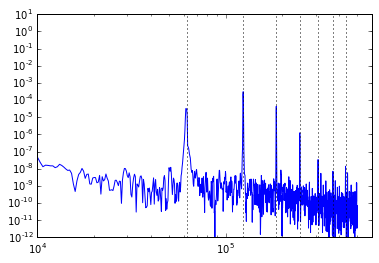

In [81]:
# plt.loglog(freq, psd)
plt.loglog(f_resid, psd_resid)
plt.xlim(1e4, 6e5)
plt.ylim(1e-12, 1e1)
for i in xrange(1, 8):
    plt.axvline(62e3*i, color='k', linestyle=':')

In [39]:
def max_in(y, x, xmin, xmax):
    m = pk.masklh(x, xmin, xmax)
    return np.max(y[m])

In [44]:
Ps = np.array([max_in(psd, freq, 62e3*i - 10e3, 62e3*i + 10e3) for i in xrange(1, 4)])

In [74]:
phi_m = np.sqrt(np.sqrt(Ps[2]/Ps[0]) * 6 )

In [75]:
delta_f = np.mean(np.gradient(freq))

In [77]:
np.sqrt(Ps[0]) / phi_m

5.9893545841464988

In [80]:
(Ps[1] * Ps[0] / Ps[2])

8.9709786877873494

In [73]:
(np.sqrt(Ps[2]/Ps[0]) * 6  * 1488**2 / (16 * np.pi**2))**0.5 * 2 # Fudge? rms?

44.451148014800808

In [28]:
(np.sqrt(Ps[2]/Ps[0]) * 6  * 1488**2 / (16 * np.pi**2))**0.5 * 2 # Fudge? rms?

array([ 1.07583558,  0.80598997, -0.01849902, ...,  0.03053848,
       -0.17978772,  0.07352686])

In [33]:
4 * np.pi / (1.488)

8.445141541908047

In [6]:
simp, simp2, simpDC = td.make_simple_opt(0.0, 1.5e-3, 30000,
                                         62e3, 1e2, 200e3, 1e6)

In [7]:
p0simp = np.array([61850.0, -30.0, 62000.0, 0.0, 0.0, 0.5e-3])
b.simp = td.fit(simp, b.t, b.x, p0=p0simp)

Response:
f   mag       dB
    0.000 1.000   -0.000
 3091.602 0.983   -0.152
 6183.205 0.927   -0.658
24732.819 0.095  -20.422
30916.024 0.011  -38.973
49465.639 0.000 -101.894
61832.049 0.000 -110.804
500000.000 0.000 -348.539


/Users/ryandwyer/anaconda/envs/1605-phasekick/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [8]:
b.simp.popt

array([  6.18402856e+04,  -3.71636578e+01,   6.20000000e+04,
         3.07606793e+01,   2.62795236e+01,   2.42798860e-04])

In [9]:
p0simp2 = np.r_[b.simp.popt[:-1], [0.1e-3, 1e-3, 0.5]]
b.simp2 = td.fit(simp2, b.t, b.x, p0=p0simp2)

Response:
f   mag       dB
    0.000 1.000   -0.000
 3091.588 0.983   -0.152
 6183.176 0.927   -0.658
24732.705 0.095  -20.422
30915.881 0.011  -38.973
49465.410 0.000 -101.894
61831.763 0.000 -110.805
500000.000 0.000 -352.605


In [10]:
b.simp2.popt

array([  6.18405126e+04,  -4.01129806e+01,   6.20000000e+04,
         3.07970930e+01,   2.62369120e+01,   1.70001261e-05,
         4.12431968e-04,   2.45417005e-01])

In [66]:
p0simpDC = np.array([  6.18406118e+04,  -4.01709611e+01,   6.20000000e+04,
        -38.063983e+00,  -1.30690501e+01,   1.90601460e-05,
         4.16560906e-04,   2.50476648e-01, 40000, 10000, 1.0])
p1simpDC = np.array([  6.18405388e+04,  -3.97535568e+01,   2.57538438e+04,
        -3.86519265e+01,  -1.26430869e+01,   5.38825741e-05,
         4.00669831e-04,   2.56587152e-01,   4.12554789e+04,
         1.08288224e+04,   1.22577851e+00])
b.simpDC = td.fit(simpDC, b.t, b.x5, p0=p1simpDC, name='simpDC',
                  tfit=b.t5)

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.173 0.983   -0.152
 6182.346 0.927   -0.658
24729.383 0.095  -20.420
30911.729 0.011  -38.968
49458.766 0.000 -101.897
61823.458 0.000 -110.811
500000.000 0.000 -336.766


In [55]:
b.simpDCDet = td.fit(simpDC, b.t, b.x5, p0=p1simpDC, name='simpDCDet',
                  tfit=b.t5)

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.173 0.983   -0.152
 6182.346 0.927   -0.658
24729.383 0.095  -20.420
30911.729 0.011  -38.968
49458.766 0.000 -101.897
61823.458 0.000 -110.811
500000.000 0.000 -336.766


In [56]:
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

([<matplotlib.axis.XTick at 0x112e8ce90>,
 <a list of 6 Text xticklabel objects>)

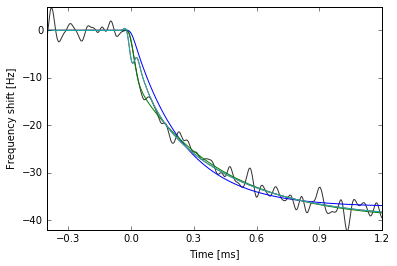

In [57]:
colors=['0.2']
colors.extend(color_cycle)

for li, color in zip([b.li, b.simp.li, b.simp2.li, b.simpDC.li, b.simpDCDet.li], colors) :
    plt.plot(li('t')*1e3, li('df'), color=color)

plt.ylabel("Frequency shift [Hz]")
plt.xlabel("Time [ms]")
plt.xlim(-0.4, 1.2)
plt.ylim(-42, 5)
plt.xticks(np.linspace(-0.3, 1.2, 6))
# plt.savefig("../../../../Talks/161109-pk-efm-theory-v2/df-time-domain.pdf")

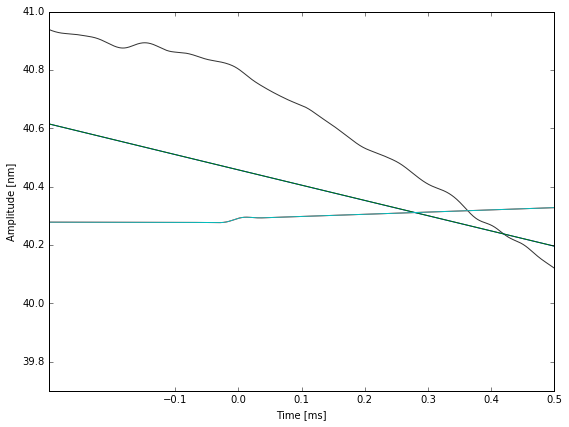

In [58]:

fig = plt.figure(figsize=(8, 6))
for li, color in zip([b.li, b.simp.li, b.simp2.li, b.simpDC.li, b.simpDCDet.li], colors) :
    plt.plot(li('t')*1e3, li('A'), color=color)

plt.ylabel("Amplitude [nm]")
plt.xlabel("Time [ms]")
plt.ylim(39.7, 41.0)
plt.xlim(-0.3, 0.5)
plt.xticks(np.linspace(-0.1, 0.5, 7))
fig.tight_layout()
# fig.savefig("../../../../Talks/161109-pk-efm-theory-v2/A-time-domain.pdf", bbox_inches='tight', transparent=True)

(<matplotlib.figure.Figure at 0x11c81e9d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c630ed0>)

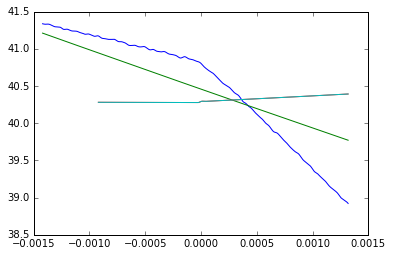

In [67]:
plot_lis([b.li, b.simp.li, b.simpDC.li, b.simpDC.li], 'A')

In [68]:
b.simpDCDet

Munch({'resid': array([ 1.04747514,  1.39952112,  1.10269415, ...,  0.16958995,
        0.21439208,  0.68681307]), 'name': 'simpDCDet', 'li': <lockin.LockIn object at 0x11bc0c8d0>, 'pcov': array([[  1.52685069e-01,  -3.89541090e-01,   1.79673608e+03,
          5.45963341e-03,  -1.66101331e-02,  -3.00719424e-07,
          2.08844085e-05,   2.74977146e-02,   1.23318760e+05,
         -2.41030264e+02,  -3.02140961e-02],
       [ -3.89541090e-01,   7.76047112e+00,  -6.40468588e+02,
         -1.70372416e-02,   5.37504206e-02,  -4.61939912e-06,
         -4.67705489e-04,  -3.24083338e-01,   1.37055925e+06,
         -5.74278882e+03,   6.70630718e-03],
       [  1.79673608e+03,  -6.40468588e+02,   2.81569276e+10,
          9.05851865e+02,  -7.48060790e+00,  -5.88021789e-01,
         -4.81042724e-01,  -1.19220652e+03,   3.90378665e+12,
         -5.32538465e+08,  -4.74842473e+05],
       [  5.45963341e-03,  -1.70372416e-02,   9.05851865e+02,
          1.11863070e-03,  -6.15555691e-04,  -3.30845854

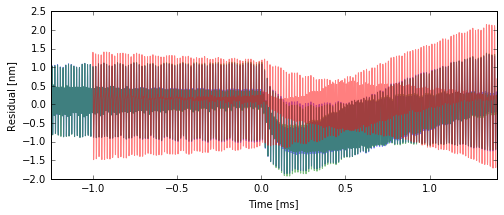

In [74]:
fig = plt.figure(figsize=(8, 3))
fits = [b.simp, b.simp2, b.simpDC]
ts = [b.t, b.t, b.t5]
for t, fit in zip(ts, fits):
    plt.plot(t*1e3, fit.resid, label=fit.name, alpha=0.5,)

plt.xlim(-1.25, 1.4)
plt.ylabel("Residual [nm]")
plt.xlabel("Time [ms]")
# fig.savefig("../../../../Talks/161109-pk-efm-theory-v2/residual-time-domain.pdf", bbox_inches='tight', transparent=True)

(-100, 500)

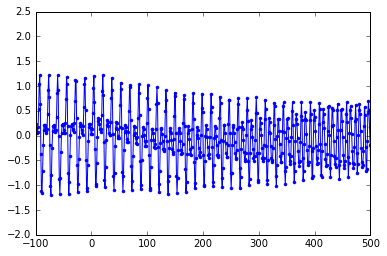

In [80]:
plt.plot(b.t5*1e6, b.simpDC.resid, '-', marker='.')
plt.xlim(-100, 500)

In [70]:
np.degrees(np.angle(1/(1 + 62e3/200e3*1j)))

-17.223436191131462

(-10, 150)

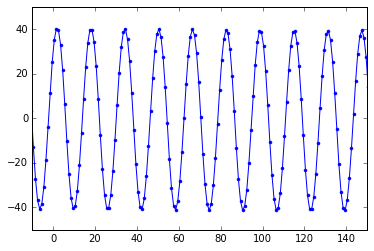

In [71]:
plt.plot(b.t5*1e6, b.x5, '-', marker='.')
plt.xlim(-10, 150)

In [72]:
print_popt(b.simpDC.popt);

f_i =  61840.5 Hz
 df =    -39.8 Hz
f_f = 103549.7 Hz
 X0 =     38.4 nm
 Y0 =     12.6 nm
 τ1 =     66.6 µs
 τ2 =    415.0 µs
  r =     0.29 
 Q0 =  3922395 
Qhv =  -203996 
 Δx =     0.56 nm
